In [1]:
# !pip install tqdm

In [2]:
import os

import gc

import json
import pickle

import signal

from datetime import datetime

import warnings

from tqdm import tqdm

from uuid import uuid4

import numpy as np

import matplotlib.pyplot as plt

import torch

from torch.utils.data import DataLoader, Subset

from torchvision.datasets import ImageFolder

from torchvision import transforms



import numpy as np

from sklearn.cluster import KMeans

import pandas as pd

from torch import nn

from torch import nn, optim

from torch.nn import (Sequential, Conv2d, MaxPool2d, ReLU, 
BatchNorm2d, Dropout, CrossEntropyLoss, AdaptiveAvgPool2d, Flatten, Linear)





if torch.cuda.is_available():

  device = "cuda"

else:

  device = "cpu"


print(f"Device: {device}")


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"


Device: cuda


In [3]:
## Some constant variables

CHECKPOINT_PATH = "/kaggle/working/"


KAGGLE_PATH = "/kaggle/input/new-plant-diseases-dataset"
KAGGLE_DOWN = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(KAGGLE_PATH, KAGGLE_DOWN, "train")
VALID_DIR = os.path.join(KAGGLE_PATH, KAGGLE_DOWN, "valid")
TEST_DIR = os.path.join(KAGGLE_PATH, "test")

In [4]:
# Class Label

TRAIN_LABELS = sorted(os.listdir(TRAIN_DIR))

VALID_LABELS = sorted(os.listdir(VALID_DIR))

TEST_LABELS = sorted(os.listdir(TEST_DIR))

In [5]:


# configurations

CONFIG = {

    "batch_size": 32,

    "num_classes": len(TRAIN_LABELS),

    "epochs": 10,

    "learning_rate": 2e-3,

    "momentum": 0.95,

    "weight_decay": 1e-4,

    "label_smoothing": 0.2,

    "scheduler_factor": 0.4,

    "min_lr": 1e-4,

    "scheduler_patience": 3,

    "scheduler_threshold": 0.05,

    'TEAM_MEMBER': 'Schadrack',

    'archetype': 'Resnet50',

    'optim': 'AdamW'

}

print(f"Configurations:\n")

for key, value in CONFIG.items():

  print(f"{key}: {value}\n")

Configurations:

batch_size: 32

num_classes: 38

epochs: 10

learning_rate: 0.002

momentum: 0.95

weight_decay: 0.0001

label_smoothing: 0.2

scheduler_factor: 0.4

min_lr: 0.0001

scheduler_patience: 3

scheduler_threshold: 0.05

TEAM_MEMBER: Schadrack

archetype: Resnet50

optim: AdamW



In [6]:
# Loading data using torchvision datasets imagefolder

# data_mean = (0.5116, 0.4026, 0.3519)

# data_std = (0.3073, 0.2697, 0.2587)

data_mean = (0.485, 0.456, 0.406)

data_std = (0.229, 0.224, 0.225)

transformations = transforms.Compose([

    transforms.Resize(size=(224, 224)),

    transforms.ToTensor(),

    transforms.Normalize(mean=data_mean, std=data_std)

]

)  # converting to tensor and resizing all images to 256x256

train_data = ImageFolder(root=TRAIN_DIR, transform=transformations)

valid_data = ImageFolder(root=VALID_DIR, transform=transformations)

test_data = ImageFolder(root=TEST_DIR, transform=transformations)

In [7]:
# Data loaders
train_loader = DataLoader(train_data,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = True,
                         num_workers = 2,
                         pin_memory  = True)


val_loader = DataLoader(valid_data,
                        batch_size=CONFIG['batch_size'],
                        shuffle     = False,
                        num_workers = 2,
                        pin_memory  = True)

test_loader = DataLoader(test_data,
                        batch_size=CONFIG['batch_size'],
                        shuffle     = False,
                        num_workers = 2,
                        pin_memory  = True)

In [8]:
def normalize_image_and_convert_to_pil(image):

  denormalize_image = transforms.Normalize(mean=[1/0.485, 1/0.456, 1/0.406], std=[1/0.229, 1/0.224, 1/0.225])(image)

  return np.array(transforms.ToPILImage()(denormalize_image))

In [9]:
def plot_pil_images(images, labels_names, labels_numbers, figsize: tuple=None):

    if len(images) == 0:

        raise ValueError("Images cannot be empty")

    rows = int(np.sqrt(len(images)))

    cols = len(images) // rows


    if cols > rows:  #  I want rows to be greater than cols
        temp = rows
        rows = cols
        cols = temp

    fig, axes = plt.subplots(nrows=rows, ncols=cols)

    if figsize and len(images)!=1:

        fig.set_size_inches(figsize[0], figsize[1])

    if len(images) == 1:

            axes.imshow(normalize_image_and_convert_to_pil(images[0]))

            axes.axis('off')

            axes.set_title(labels_names[0])

    elif len(images) < 3:
        for i in range(len(images)):
            axes[i].imshow(normalize_image_and_convert_to_pil(images[i]))

            axes[i].axis('off')

            axes[i].set_title(labels_names[i])
    else:

        count_image = 0

        for row in range(rows):

            for col in range(cols):

                axes[row, col].imshow(normalize_image_and_convert_to_pil(images[count_image]))

                axes[row, col].axis('off')

                axes[row, col].set_title(labels_names[count_image])

                count_image += 1

    plt.show()

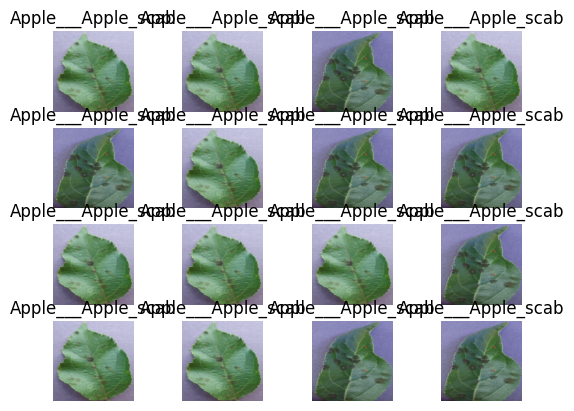

In [10]:
# Viewing random samples

sample_images_indicies = np.random.randint(0, len(test_loader), size=(16,))

sample_images, sample_lables = [], []

labels_num = []

for indx in sample_images_indicies:

  img, label = train_data[indx]

  sample_images.append(img)

  sample_lables.append(VALID_LABELS[label])

  labels_num.append(label)

# View sample images from train

plot_pil_images(sample_images, sample_lables, labels_num)

In [11]:
gc.collect()

if torch.cuda.is_available():

    torch.cuda.empty_cache()

    torch.cuda.memory_summary(device=device, abbreviated=False)

# testing data loaders

for Xb, yb in test_loader:

  Xb, yb = Xb.to(device), yb.to(device)

  print(f"Images shape: {Xb.shape}")

  print(f"Labels shape: {yb.shape}")

  break


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


# Resnet Architecture

In [12]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, expansion, identity_downsample = None, stride=1):

        super(Block, self).__init__()

        self.expansion = expansion

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)

        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, padding=0, stride=1)

        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.gelu = nn.GELU()

        self.identity_downsample = identity_downsample



    def forward(self, x):

        identity = x.clone()

        x = self.conv1(x)

        x = self.bn1(x)

        x = self.gelu(x)



        x = self.conv2(x)

        x = self.bn2(x)

        x = self.gelu(x)



        x = self.conv3(x)

        x = self.bn3(x)



        if self.identity_downsample is not None:

            identity = self.identity_downsample(identity)



        x += identity

        x = self.gelu(x)

        return x

In [13]:
class ResNet(nn.Module):

    def __init__(self, block, layers, image_channels, out_channels, expansion, num_classes):

        super(ResNet, self).__init__()

        self.in_channels = image_channels

        self.conv1 = nn.Conv2d(self.in_channels, self.in_channels, kernel_size = 7, stride = 1, padding = 3) # output shape 224 -> When input shape is 224

        self.bn1 = nn.BatchNorm2d(self.in_channels)

        self.gelu = nn.GELU()

        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3) # output shape 73x73





        # REsnet Layers

        self.layer1 = self._make_layer(block, layers[0], out_channels=out_channels, stride=1, expansion=expansion) # output 73

        self.layer2 = self._make_layer(block, layers[1], out_channels=out_channels * expansion//2, stride=2, expansion=expansion) # output 33

        self.layer3 = self._make_layer(block, layers[2], out_channels=out_channels * expansion, stride=2, expansion=expansion) # output 33

        self.layer4 = self._make_layer(block, layers[3], out_channels=out_channels * expansion * 2, stride=2, expansion=expansion) # output 33



        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))



        self.fc = nn.Linear(out_channels * expansion * 2 * expansion * 5 * 5, num_classes)



    def forward(self, x, return_features=False):

        x = self.conv1(x)

        x = self.bn1(x)

        x = self.gelu(x)

        x = self.maxpool(x)



        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)



        x = self.avgpool(x)

        x = x.reshape(x.shape[0], -1) # Reshaping before sending to the fully connected layer



        if return_features:

          return x



        x = self.fc(x)



        return x



    def _make_layer(self, block, num_residual_blocks, out_channels, stride, expansion):

        identity_downsample = None

        layers = []



        if stride != 1 or self.in_channels != out_channels * expansion:

            identity_downsample = nn.Sequential(

                nn.Conv2d(self.in_channels, out_channels * expansion, kernel_size=1, stride=stride),

                nn.BatchNorm2d(out_channels * expansion)

            )



        layers.append(block(self.in_channels, out_channels, expansion, identity_downsample, stride))

        self.in_channels = out_channels * expansion



        for i in range(1, num_residual_blocks):

            layers.append(block(self.in_channels, out_channels, expansion))



        return nn.Sequential(*layers)

In [14]:
class Resnet50(ResNet):

    def __init__(self, block, image_channels, out_channels, expansion, num_classes):

        super(Resnet50, self).__init__(block, [3, 4, 6, 3], image_channels, out_channels, expansion, num_classes)

        self.database = {} # keeps class with its corresponding features which will be used for dot product predictions



    def train_model(self, optimizer, dataloader, criterion, scaler, device='cpu'):

        self.train() # put the model into train mode

        total_batches = len(dataloader)

        num_correct = 0

        train_acc = 0

        total_loss = 0

        total_images = 0 # images model has already seen

        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)



        for index, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device) # moving data to same device with the model

            total_images += len(images)

            optimizer.zero_grad() # zeroing the previous gradients

            with torch.cuda.amp.autocast(): # allowing mixed precission during forward propagation

                logits = self(images) # forward pass

                loss = criterion(logits, labels) # calculating the loss/divergence



            # Find number of correct predictions and add them to previous correct total of predictions

            num_correct += int((torch.argmax(logits, axis=1) == labels).sum()) # make summation and cast it to integer

            train_acc = num_correct * 100 / total_images

            total_loss += float(loss.item()) # find the loss



            # Adding monitoring data to tqdm bar

            batch_bar.set_postfix(

                train_acc="{:.04f}%".format(train_acc),

                train_loss="{:.04f}".format(total_loss / (index + 1)),

                correct_preds="{}".format(num_correct),

                lr="{:.04f}".format(optimizer.param_groups[0]['lr'])

            )



            batch_bar.update()



            # Backward pass

            scaler.scale(loss).backward()



            # Gradient descent to update parameter

            scaler.step(optimizer)

            scaler.update()



            # Release some memory

            del images, labels, logits



            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()

        total_loss /= total_batches



        return train_acc, total_loss





    def validate_model(self, dataloader, criterion, device='cpu'):

        self.eval() # put the model into evaluation mode

        total_batches = len(dataloader)

        num_correct = 0

        val_acc = 0

        val_loss = 0

        total_images = 0 # images model has already seen

        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Validation', ncols=5)



        for index, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)

            total_images += len(images)

            with torch.inference_mode(): # inferring

                logits = self(images) # forward pass

                loss = criterion(logits, labels) # Loss calculation



            num_correct += int((torch.argmax(logits, axis=1) == labels).sum())

            val_acc = num_correct * 100 / total_images

            val_loss = loss.item()



            # Adding monitoring data to tqdm bar

            batch_bar.set_postfix(

                train_acc="{:.04f}%".format(val_acc),

                train_loss="{:.04f}".format(val_loss / (index + 1)),

                correct_preds="{}".format(num_correct)

            )



            batch_bar.update()



            del images, labels, logits



            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()

        val_loss /= total_batches



        return val_acc, val_loss





    def predict_with_classifier(self, dataloader, device='cpu', labels_names=None):

        self.eval() # put the model into evaluation mode

        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Classifier Predict', ncols=5)

        prediction_results = []

        for index, images in enumerate(dataloader):

            if type(images) in [tuple, list]:

              images = images[0]

            images = images.to(device)

            with torch.inference_mode():

                logits = self(images)



            # detaching the from the computational graph and convert result to list

            logits = torch.argmax(logits, axis=1).detach().cpu().numpy().tolist()

            prediction_results.extend(logits)



            batch_bar.update()

            del logits



            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()



        if labels_names: # return predicted class names

            predicted_classes = []

            for prediction in prediction_results:

              predicted_classes.append(labels_names[prediction])



            return prediction_results, predicted_classes



        return prediction_results







    def extract_best_features_by_clustering(self, features):

        # Apply Clustering Algorithm

        n_clusters = 5 # The number of clusters, because we need one D

        cluster_model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)

        cluster_model.fit(features)



        # Obtain Cluster Representations

        cluster_assignments = cluster_model.predict(features)

        cluster_centers = cluster_model.cluster_centers_



        # Generate Final Feature Vector

        # final_feature_vector = np.concatenate(cluster_centers, axis=0)  # Concatenate cluster centers



        return torch.tensor(cluster_centers.mean(axis=0))





    def extract_features(self, dataloader, label_names, extractor_func='mean', device='cpu'):

        """

        This method extracts the features and keeps them in the self.database

        These features will be used for making predictions with dot product

        params:

          extractor_func: this is a function to be use for either everaging or choosing the mean

        """

        self.eval()  # put the model into evaluation mode



        for label_name in label_names: # Removing the existing classes in database

            self.drop_class(label_name, False)



        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Features Extractor', ncols=5)

        for images, labels in dataloader:

            images = images.to(device) # return features

            with torch.inference_mode():

                features_batch = self(images, return_features=True)



            # detaching the from the computational graph and convert result to list

            features_batch = features_batch.detach().cpu().numpy().tolist()

            for features, actual_label in zip(features_batch, labels.cpu().numpy().tolist()):

                    if label_names[actual_label] in label_names:

                        self.database[label_names[actual_label]] = self.database.get(label_names[actual_label], []) + [features]





            batch_bar.update()



            del features

            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()

        # Taking the average of features accross each image

        message = extractor_func.lower().capitalize() + " Features" if extractor_func.lower()!= "mean" else "Averaging Features"

        batch_bar = tqdm(total=len(self.database), dynamic_ncols=True, leave=False, position=0, desc=message, ncols=5)

        for key, value in self.database.items():

            if key in label_names:

                if extractor_func.lower() == 'median':

                    self.database[key] = torch.median(torch.tensor(value).to(device=device), axis=0).values

                elif extractor_func.lower() == 'clustering':

                    self.database[key] = self.extract_best_features_by_clustering(torch.tensor(value).to(device=device).detach().cpu().numpy()).to(device)

                else:

                    self.database[key] = torch.mean(torch.tensor(value).to(device=device), axis=0)



            batch_bar.update()



            del key, value



            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()





    def predict_with_dot_product(self, dataloader, device='cpu'):

        self.eval() # put the model into evaluation mode

        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Dot Product Predict', ncols=5)

        prediction_results = []

        values = list(model.database.values())

        database_features = torch.cat(values, dim=0).view(-1, len(values[0]))

        database_labels = list(self.database.keys())



        del values



        for index, images in enumerate(dataloader):

            if type(images) in [tuple, list]:

              images = images[0]

            images = images.to(device)

            with torch.inference_mode():

                features = self(images, return_features=True)



            # detaching the from the computational graph and convert result to list

            database_features = database_features.to(dtype=images.dtype)

            logits = database_features @ features.T

            logits = torch.argmax(logits, axis=0).detach().cpu().numpy().tolist()

            prediction_results.extend(logits)



            batch_bar.update()

            del logits



            if torch.cuda.is_available():

                torch.cuda.empty_cache()



        batch_bar.close()



        predicted_classes = []

        for prediction in prediction_results:

            predicted_classes.append(database_labels[prediction])



        del prediction_results



        return predicted_classes





    def get_database_len(self):

      return len(list(self.database.keys()))





    def get_database_classes(self):

      return list(self.database.keys())





    def get_database(self):

      return self.database





    def drop_class(self, class_name, print_msg=True):

      if self.database.get(class_name, None) is not None:

          del self.database[class_name]

      else:

        if print_msg:

            print(f"\nClass {class_name}\n")

In [15]:
# Function for setting the states checkpoints

def save_checkpoint(path, model, optimizer, train_acc, train_loss, valid_acc, valid_loss, epoch, learning_rate, scheduler=None):

    """

        Function saves different objects states

        args:

            model: the model to be saved

            optimizer: The optimizer to be saved

            epoch -> int: The epoch to be saved

            learning_rate -> decimal: The learning rate to be save

            scheduler: the scheduler to be saved

    """

    checkpoint = {

        "model_state": model.to("cpu").state_dict(),

        "optimizer_state": optimizer.state_dict(),

        "epoch": epoch,

        "learning_rate": learning_rate,

        "train_acc": train_acc,

        "train_loss": train_loss,

        "valid_acc": valid_acc,

        "valid_loss": valid_loss,

        "database": model.database

    }



    if scheduler:

        checkpoint["scheduler_state"] = scheduler.state_dict()



    torch.save(checkpoint, path)
    path = path.replace(".pth", ".pkl")
    torch.save(checkpoint, path)


# Function for loading checkpoint

def load_checkpoint(path, model, optimizer, scheduler=None, device='cpu'):

    checkpoint = torch.load(path, map_location=device)



    model.load_state_dict(checkpoint["model_state"])

    optimizer.load_state_dict(checkpoint["optimizer_state"])

    epoch = checkpoint["epoch"]

    learning_rate = checkpoint["learning_rate"]

    train_acc = checkpoint["train_acc"]

    train_loss = checkpoint["train_loss"]

    valid_acc = checkpoint["valid_acc"]

    valid_loss = checkpoint["valid_loss"]

    database = checkpoint["database"]



    model.database = database



    if scheduler:

        scheduler.load_state_dict(checkpoint["scheduler_state"])

        return model, optimizer, scheduler, learning_rate, epoch, train_acc, train_loss, valid_acc, valid_loss

    else:

        return model, optimizer, scheduler, learning_rate, epoch, train_acc, train_loss, valid_acc, valid_loss







# Function for setting the states checkpoints

def save_model_checkpoint(path, model, device='cpu'):

    """

        Function saves  model state

        args:

            model: the model to be saved

    """

    checkpoint = torch.load(path, map_location=device)

    checkpoint["model_state"] = model.state_dict()

    checkpoint["database"] = model.database



    torch.save(checkpoint, path)



# function which loads only the model

def load_model_checkpoint(path, model):

    checkpoint = torch.load(path, map_location=device)



    model.load_state_dict(checkpoint["model_state"])

    database = checkpoint["database"]



    model.database = database



    return model

In [16]:
gc.collect()

if torch.cuda.is_available():

    torch.cuda.empty_cache()

    torch.cuda.memory_summary(device=device, abbreviated=False)



# Tesing the model creation

model = Resnet50(Block, Xb.shape[1], 62, 4, CONFIG["num_classes"]).to(device)

In [17]:
def get_model_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params

In [18]:
print(f"Model trainable parameters: {get_model_parameters(model)}")

Model trainable parameters: 23947058


# Setting up optimizer, schedulers, scalers and loss function

In [19]:
# defining optimizer

optimizer = optim.AdamW(model.parameters(),

                      lr=CONFIG['learning_rate'],

                      # momentum=CONFIG['momentum'],

                      weight_decay=CONFIG['weight_decay'])



# loss function

criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])



# scheduler

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,

                                                 mode='max',

                                                 factor= CONFIG['scheduler_factor'],

                                                 patience=CONFIG['scheduler_patience'],

                                                 min_lr=CONFIG['min_lr'],

                                                threshold=CONFIG['scheduler_threshold'])

# Defining scaler

if torch.cuda.is_available():
    scaler = torch.amp.GradScaler("cuda")
else:
    scaler = torch.cuda.amp.GradScaler()

# Wandb Set up

In [20]:
gc.collect()

if torch.cuda.is_available():

    torch.cuda.empty_cache()

    torch.cuda.memory_summary(device=device, abbreviated=False)

# Running Experiments

In [21]:
checkpoint_name = "best_checkpoint.pth"

checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_name)

experiments_logs_path = os.path.join(CHECKPOINT_PATH, 'Experiments')

os.makedirs(experiments_logs_path, exist_ok = True)

In [23]:
if torch.cuda.is_available():

    torch.cuda.empty_cache()

gc.collect()

best_valid_acc = 0

e = 0

epoch_time_ellapse = {}
RESUME_LOGGING = False

if RESUME_LOGGING:

    (model, optimizer, scheduler, curr_lr, e,

     train_acc, train_loss, best_valid_acc, valid_loss) = load_checkpoint(checkpoint_path, model, optimizer, scheduler, device)


    print("""Resuming from epoch {} with \ntrain acc: {:.04f}% val acc: {:.04f}% train loss: {:.04f}

    valid loss: {:.04f} lr: {:.04f}\n Optimizer: """.format(e, train_acc, best_valid_acc, train_loss, valid_loss, curr_lr, optimizer))


if torch.cuda.is_available():

    torch.cuda.empty_cache()

gc.collect()

if e == CONFIG["epochs"]:

    CONFIG["epochs"] += 5


with open(f'{experiments_logs_path}/experiment_log.txt', "w") as f:

    for epoch in range(e, CONFIG["epochs"] + 1):

        epoch_start_time = datetime.now()

        epoch_line = "\nEpoch {}/{}".format(epoch+1, CONFIG['epochs'])

        print(epoch_line)

        curr_lr = float(optimizer.param_groups[0]['lr'])

        train_acc, train_loss = model.train_model(optimizer, train_loader, criterion, scaler, device)

        val_acc, val_loss     = model.validate_model(val_loader, criterion, device)


        epoch_line += "\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc, train_loss, curr_lr)

        epoch_line += "\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc, val_loss)

        print(epoch_line)

        if scheduler is not None:
            scheduler.step(val_acc)


        if val_acc > best_valid_acc:
            best_valid_acc = val_acc
            save_checkpoint(checkpoint_path, model, optimizer, train_acc, train_loss, val_acc, val_loss, epoch, curr_lr, scheduler)

            print("\nSaved the best model\n")

            epoch_line += "\nSaved the best model\n"

        time_epoch_took = (datetime.now() - epoch_start_time).seconds

        print(f"Epoch {epoch + 1} took: {time_epoch_took // 60} minutes and {time_epoch_took % 60 } seconds")

        epoch_line += f"Epoch {epoch + 1} took: {time_epoch_took // 60} minutes and {time_epoch_took % 60 } seconds"


        epoch_time_ellapse[epoch] = time_epoch_took

        f.writelines(epoch_line)

    f.close()

with open(f'{experiments_logs_path}/epoch_time_ellapse.json', 'w') as f:

    json.dump(epoch_time_ellapse, f)

    f.close()

print(f"Best Validation Accuracy: {best_valid_acc}")

In [ ]:
with open("classes.json", "w") as f:
    json.dump(TRAIN_LABELS, f)